In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from typing import Tuple, List
import os
import re

In [2]:
import pandas as pd
from typing import Tuple
import re

def parse_filenames(df: pd.DataFrame) -> pd.DataFrame:
    """Processes a DataFrame to extract sample, sampler, and method from filenames.
    
    It reads from a column 'Unnamed: 0', and creates 'sample',
    'sampler', and 'method' columns, then drops the original column.

    Args:
        df: The input pandas DataFrame.

    Returns:
        A new DataFrame with the processed columns.
    """
    
    # Work on a copy to avoid side effects and SettingWithCopyWarning
    df_copy = df.copy()
    
    # The name of the column containing the filenames
    filename_col = 'Unnamed: 0'

    def parse_filename(filename: str) -> Tuple[str, str, str]:
        """Parses a filename to extract sample, sampler, and method.

        Handles formats like:
        - `doublet_1_NR_groupwise` -> sample: 1, sampler: NR, method: groupwise
        - `doublets_1_null_singlets_groupwise` -> sample: 1, sampler: RJ, method: groupwise
        - `flowmop_doublets_1` -> sample: 1, sampler: FlowMOP, method: groupwise

        Args:
            filename: The filename string to parse.

        Returns:
            A tuple containing the sample, sampler, and method.
        """
        
        # Clean the filename by removing the extension and any whitespace
        clean_name = filename.replace('.fcs', '').strip()
        parts = clean_name.split('_')
        
        sample, sampler, method = '', '', ''

        # Handle flowmop format: e.g., flowmop_doublets_1 or flowmop_doublet_4
        if parts[0] == 'flowmop' and parts[1].startswith('doublet'):
            sample = parts[2]
            sampler = 'FlowMOP'
            method = 'groupwise'

        # Handle other doublet formats
        elif parts[0].startswith('doublet'):
            sample = parts[1]
            method = parts[-1]
            
            if 'null' in parts:
                sampler = 'RJ'
            elif 'SC' in parts: 
                sampler = 'SC'
            else:
                sampler = parts[2]
            
        return sample, sampler, method

    # Apply the parsing function to the column to create new columns
    df_copy[['sample', 'sampler', 'method']] = df_copy[filename_col].apply(
        lambda name: pd.Series(parse_filename(name))
    )
    
    # Drop the original 'Unnamed: 0' column
    df_processed = df_copy.drop(columns=[filename_col])
    
    return df_processed

In [4]:
synth_dir = r"D:\github_remotes\flowmop_paper\figs_data\fig_2_data\fig_2_analysis"

csvs = [f for f in os.listdir(synth_dir) if f.endswith('.csv')]
doublet_data = [pd.read_csv(synth_dir + "\\" + csv) for csv in csvs if 'doublet' in csv]
for i, doublet in enumerate(doublet_data): 
    doublet_data[i] = doublet_data[i][~doublet_data[i]['Unnamed: 0'].str.contains('Mean', na=False)]
    doublet_data[i] = doublet_data[i][~doublet_data[i]['Unnamed: 0'].str.contains('SD', na=False)]

for i, time in enumerate(doublet_data): 
    doublet_data[i] = parse_filenames(time).sort_values(by="sample").reset_index(drop=True)
original_count = doublet_data[0]["Count"]
original_doublets = doublet_data[0]["Q2: CTV+ , CFSE+ | Freq. of Parent (%)"]
doublet_data[0]["Count"] = doublet_data[0]["Count"] * doublet_data[0]["passeddoublet subset | Freq. of Parent (%)"]/100

In [5]:
doublet_data[0].rename(columns={
    "passeddoublet subset/Q2: CTV+ , CFSE+ | Freq. of Parent (%)":"doublets",
    }, inplace=True)
# Drop all columns containing '|' in their names
columns_to_drop = [col for col in doublet_data[0].columns if '|' in col]
doublet_data[0].drop(columns=columns_to_drop, inplace=True)
doublet_data[0].drop(columns=["Unnamed: 11"], inplace=True)

doublet_data[1].drop("Unnamed: 5", axis=1, inplace=True)
doublet_data[1].rename(columns={
    "Q2: CTV+ , CFSE+ | Freq. of Parent (%)": "doublets",
    }, inplace=True)
# Drop all columns containing '|' in their names
columns_to_drop = [col for col in doublet_data[1].columns if '|' in col]
doublet_data[1].drop(columns=columns_to_drop, inplace=True)
doublet_data[1].drop([6], inplace=True)

In [6]:
all_doublets = pd.concat([doublet_data[0], doublet_data[1]])

In [12]:
flowmop_data = all_doublets[all_doublets['sampler'] == 'FlowMOP']
from scipy import stats

# Perform paired t-test between initial_sample and flowmop_data doublets
t_stat, p_value = stats.ttest_rel(original_doublets, flowmop_data['doublets'])

print(f"Paired t-test results:")
print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

# Print summary statistics for context
print(f"\nSummary statistics:")
print(f"Initial sample mean: {original_doublets.mean():.2f}")
print(f"FlowMOP doublets mean: {flowmop_data['doublets'].mean():.2f}")
print(f"Initial sample std: {original_doublets.std():.2f}")
print(f"FlowMOP doublets std: {flowmop_data['doublets'].std():.2f}")



Paired t-test results:
t-statistic: 12.2388
p-value: 0.0012

Summary statistics:
Initial sample mean: 7.84
FlowMOP doublets mean: 0.27
Initial sample std: 1.21
FlowMOP doublets std: 0.11


In [7]:
# Create a mapping from sample ID to the original doublet percentage.
# We know 'original_doublets' corresponds to samples '1', '2', '3', '4' in order,
# because the DataFrame was sorted by sample before 'original_doublets' was extracted.
sample_ids = sorted(all_doublets['sample'].unique())
original_doublets_map = pd.Series(original_doublets.values, index=sample_ids)

# Create a copy to avoid SettingWithCopyWarning
all_doublets_copy = all_doublets.copy()

# Map the original doublet values to the all_doublets DataFrame based on the 'sample' column
all_doublets_copy['original_doublet'] = all_doublets_copy['sample'].map(original_doublets_map)

# Calculate the difference
all_doublets_copy['doublet_difference'] = 100 - (all_doublets_copy['original_doublet'] - all_doublets_copy['doublets'])

C:\Users\xuton\AppData\Local\Temp\ipykernel_110784\2529906651.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\xuton\AppData\Local\Temp\ipykernel_110784\2529906651.py:87: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


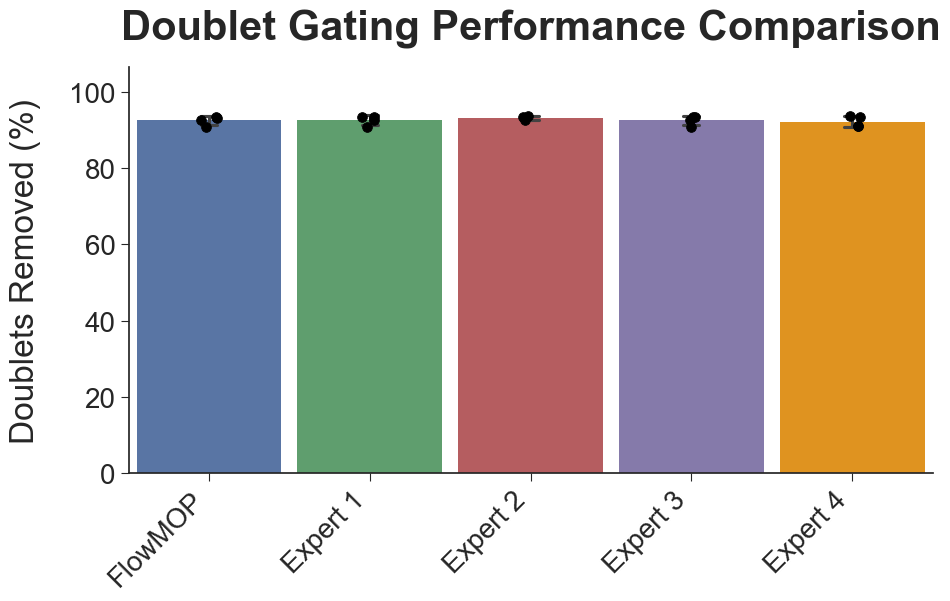

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
import pandas as pd

# Big fonts (same as other figures)
BIG_FONTS = {
    "base": 22,
    "title": 30,
    "label": 24,
    "tick": 20,
    "legend": 20,
    "annot": 22,
}

plt.rcParams.update({
    "font.size": BIG_FONTS["base"],
    "axes.titlesize": BIG_FONTS["title"],
    "axes.labelsize": BIG_FONTS["label"],
    "xtick.labelsize": BIG_FONTS["tick"],
    "ytick.labelsize": BIG_FONTS["tick"],
    "legend.fontsize": BIG_FONTS["legend"],
    "legend.title_fontsize": BIG_FONTS["legend"],
})

# --- 1. Data Preparation ---
plot_df = all_doublets_copy[
    (all_doublets_copy["method"] == "samplewise") |
    (all_doublets_copy["sampler"] == "FlowMOP")
].copy()

anonymize_map = {
    "FlowMOP": "FlowMOP",
    "FMW": "Expert 1",
    "NR": "Expert 3",
    "RJ": "Expert 4",
    "SC": "Expert 2",
}
plot_df["sampler_anonymized"] = plot_df["sampler"].map(anonymize_map)

# --- 2. Statistical Analysis (Paired t-test) ---
flowmop_scores = (
    plot_df[plot_df["sampler_anonymized"] == "FlowMOP"]
    .set_index("sample")["doublet_difference"]
)

p_values = {}
experts = ["Expert 1", "Expert 2", "Expert 3", "Expert 4"]
for expert in experts:
    expert_scores = (
        plot_df[plot_df["sampler_anonymized"] == expert]
        .set_index("sample")["doublet_difference"]
    )

    merged_scores = pd.merge(
        flowmop_scores.rename("flowmop"),
        expert_scores.rename("expert"),
        left_index=True,
        right_index=True,
    )

    t_stat, p_val = stats.ttest_rel(merged_scores["flowmop"], merged_scores["expert"])
    p_values[expert] = p_val

n_tests = len(p_values)

# --- 3. Plotting ---
plt.style.use("seaborn-v0_8-ticks")
fig, ax = plt.subplots(figsize=(12, 7))  # wide, short

order = ["FlowMOP", "Expert 1", "Expert 2", "Expert 3", "Expert 4"]
palette = ["#4c72b0", "#55a868", "#c44e52", "#8172b2", "#ff9900"]

sns.barplot(
    x="sampler_anonymized",
    y="doublet_difference",
    data=plot_df,
    order=order,
    palette=palette,
    errorbar="sd",
    capsize=0.1,
    width=0.9,        # fatter bars
    ax=ax,
)

sns.stripplot(
    x="sampler_anonymized",
    y="doublet_difference",
    data=plot_df,
    order=order,
    color="black",
    size=7,
    jitter=0.05,
    edgecolor="gray",
    linewidth=0.6,
    ax=ax,
)

ax.set_title(
    "Doublet Gating Performance Comparison",
    fontsize=BIG_FONTS["title"],
    weight="bold",
    pad=20,
)
ax.set_xlabel("")
ax.set_ylabel("Doublets Removed (%)", fontsize=BIG_FONTS["label"])
ax.tick_params(axis="both", which="major", labelsize=BIG_FONTS["tick"])

# rotate x labels and add left space
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
ax.yaxis.labelpad = 20
fig.subplots_adjust(left=0.23, bottom=0.3)

sns.despine()

# --- 4. Significance bars ---
def add_significance_bar(x1, x2, p_corrected, y_pos, ax):
    """Draws a significance bar between two x-levels."""
    if p_corrected >= 0.05:
        return

    if p_corrected < 0.001:
        s_text = "***"
    elif p_corrected < 0.01:
        s_text = "**"
    else:
        s_text = "*"

    tick_len = 0.5

    ax.plot([x1, x2], [y_pos, y_pos], c="k", lw=1.4)
    ax.plot([x1, x1], [y_pos - tick_len, y_pos], c="k", lw=1.4)
    ax.plot([x2, x2], [y_pos - tick_len, y_pos], c="k", lw=1.4)

    ax.text(
        (x1 + x2) / 2,
        y_pos + tick_len,
        s_text,
        va="bottom",
        ha="center",
        fontsize=BIG_FONTS["annot"],
        weight="bold",
    )

max_y = plot_df.groupby("sampler_anonymized")["doublet_difference"].apply(
    lambda x: x.mean() + x.std()
).max()
bar_y_pos = max_y * 1.08
y_increment = max_y * 0.1

x_flowmop = order.index("FlowMOP")
for expert in order[1:]:
    p_corrected = min(p_values[expert] * n_tests, 1.0)
    if p_corrected < 0.05:
        x_expert = order.index(expert)
        add_significance_bar(x_flowmop, x_expert, p_corrected, bar_y_pos, ax)
        bar_y_pos += y_increment

ax.set_ylim(top=bar_y_pos * 1.05)

plt.show()


Could not perform t-test for Expert 2: unequal number of samples or no samples.
0.1895277320248723
1.0
0.009447103911477833
0.735739355648461


C:\Users\xuton\AppData\Local\Temp\ipykernel_110784\3651423070.py:74: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:black'` for the same effect.

  sns.stripplot(
C:\Users\xuton\AppData\Local\Temp\ipykernel_110784\3651423070.py:74: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(


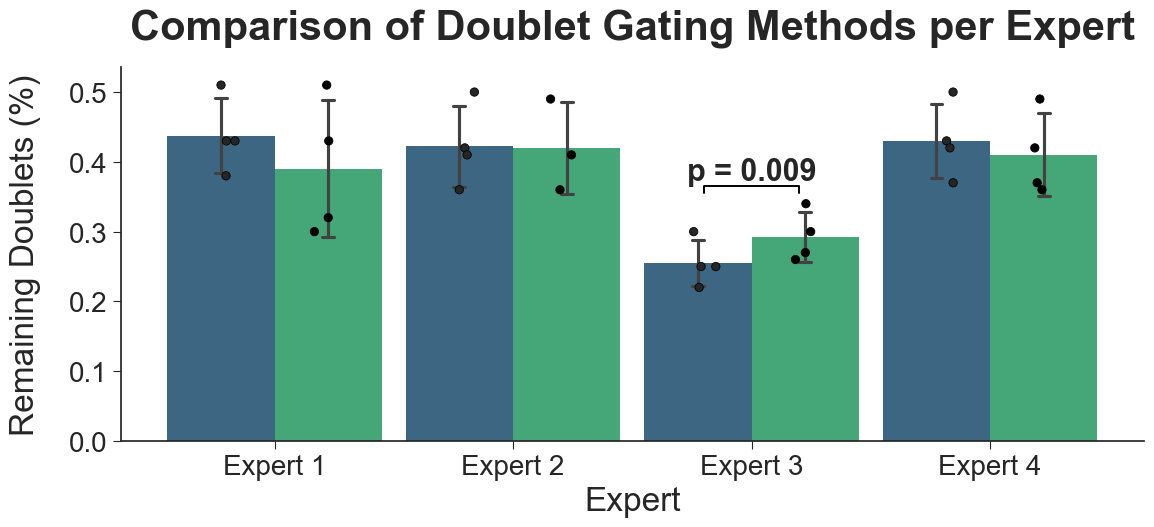

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
import pandas as pd

# 1. Data Preparation
experts_df = all_doublets[all_doublets["sampler"] != "FlowMOP"].copy()

anonymize_map = {
    "FMW": "Expert 1",
    "NR": "Expert 3",
    "RJ": "Expert 4",
    "SC": "Expert 2",
}
experts_df["sampler_anonymized"] = experts_df["sampler"].map(anonymize_map)
experts_df["method"] = experts_df["method"].str.replace("wise", "").str.capitalize()

# 2. Paired T-tests: Group vs Sample for each expert
p_values_method_comparison = {}
experts = ["Expert 1", "Expert 2", "Expert 3", "Expert 4"]

for expert in experts:
    expert_df = experts_df[experts_df["sampler_anonymized"] == expert]

    groupwise_scores = (
        expert_df[expert_df["method"] == "Group"]
        .sort_values("sample")["doublets"]
    )
    samplewise_scores = (
        expert_df[expert_df["method"] == "Sample"]
        .sort_values("sample")["doublets"]
    )

    if len(groupwise_scores) == len(samplewise_scores) and len(groupwise_scores) > 0:
        t_stat, p_val = stats.ttest_rel(groupwise_scores, samplewise_scores)
        p_values_method_comparison[expert] = p_val
    else:
        print(
            f"Could not perform t-test for {expert}: "
            "unequal number of samples or no samples."
        )
        p_values_method_comparison[expert] = 1.0

# 3. Create the Plot (uses BIG_FONTS from other cells)
plt.style.use("seaborn-v0_8-ticks")
plt.rcParams.update({
    "font.size": BIG_FONTS["base"],
    "axes.titlesize": BIG_FONTS["title"],
    "axes.labelsize": BIG_FONTS["label"],
    "xtick.labelsize": BIG_FONTS["tick"],
    "ytick.labelsize": BIG_FONTS["tick"],
    "legend.fontsize": BIG_FONTS["legend"],
    "legend.title_fontsize": BIG_FONTS["legend"],
})

fig, ax = plt.subplots(figsize=(12, 7))

order = ["Expert 1", "Expert 2", "Expert 3", "Expert 4"]

sns.barplot(
    x="sampler_anonymized",
    y="doublets",
    hue="method",
    data=experts_df,
    order=order,
    palette="viridis",
    errorbar="sd",
    capsize=0.1,
    width=0.9,
    ax=ax,
)

sns.stripplot(
    x="sampler_anonymized",
    y="doublets",
    hue="method",
    data=experts_df,
    order=order,
    dodge=True,
    color="black",
    size=6,
    jitter=0.1,
    edgecolor="gray",
    linewidth=0.6,
    ax=ax,
)

# 4. Add Significance Annotations
def format_p_value(p):
    if p < 0.001:
        return "p < 0.001"
    elif p < 0.01:
        return f"p = {p:.3f}"
    else:
        return f"p = {p:.2f}"

def add_significance_bracket(x_center, p_val, ax, experts_df, order):
    if p_val >= 0.05:
        return

    expert_name = order[int(round(x_center))]
    group_data = experts_df[experts_df["sampler_anonymized"] == expert_name]

    max_y = 0
    for method in ["Group", "Sample"]:
        method_data = group_data[group_data["method"] == method]["doublets"]
        if not method_data.empty:
            mean_val = method_data.mean()
            std_val = method_data.std()
            max_y = max(max_y, mean_val + std_val)

    bar_width = 0.4
    x1 = x_center - bar_width / 2
    x2 = x_center + bar_width / 2

    ylim_top = ax.get_ylim()[1]
    y_bracket = max_y + 0.05 * ylim_top
    bracket_height = 0.02 * ylim_top

    ax.plot(
        [x1, x1, x2, x2],
        [y_bracket, y_bracket + bracket_height,
         y_bracket + bracket_height, y_bracket],
        c="k",
        lw=1.4,
    )

    ax.text(
        (x1 + x2) / 2,
        y_bracket + bracket_height,
        format_p_value(p_val),
        ha="center",
        va="bottom",
        fontsize=BIG_FONTS["annot"],
        weight="bold",
    )

for i, expert in enumerate(order):
    if expert in p_values_method_comparison:
        p_val = p_values_method_comparison[expert]
        print(p_val)
        add_significance_bracket(i, p_val, ax, experts_df, order)

# 5. Final Touches
ax.set_title(
    "Comparison of Doublet Gating Methods per Expert",
    fontsize=BIG_FONTS["title"],
    weight="bold",
    pad=20,
)
ax.set_xlabel("Expert", fontsize=BIG_FONTS["label"])
ax.set_ylabel("Remaining Doublets (%)", fontsize=BIG_FONTS["label"])
ax.tick_params(axis="both", which="major", labelsize=BIG_FONTS["tick"])
ax.yaxis.labelpad = 20

# Legend at the bottom, de-duplicated
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
handles = list(by_label.values())
labels = list(by_label.keys())

if ax.get_legend() is not None:
    ax.get_legend().remove()

# fig.legend(
#     handles[:2],
#     labels[:2],
#     title="Method",
#     bbox_to_anchor=(0.5, 0.02),
#     loc="lower center",
#     ncol=2,
#     frameon=False,
#     fontsize=BIG_FONTS["legend"],
#     title_fontsize=BIG_FONTS["legend"],
# )

sns.despine()
plt.tight_layout(rect=[0, 0.18, 1, 1])
plt.show()